In [242]:
using JuMP, Ipopt
using Plots

basicTerrain(x, y) = exp(-1(x^2 + y^2)) + 0.5 * exp(-0.5((x-2)^2 + y^2))

function potential(vec)
    return basicTerrain(vec[1], vec[2])
end

k = 4              
instances = zeros(Int,4)  
wps = zeros(2,k)    

instances[1] = 1
instances[2] = 30
instances[3] = 70
instances[4] = 100

# define waypoints
wps = [-2 -2;
        0  0;
        1  0;
       -2 -2]

function least_dangerous(λ, ξ) 

    m = Model(Ipopt.Optimizer)
    register(m, :basicTerrain, 2, basicTerrain, autodiff=true)
    set_optimizer_attributes(m, "print_level" => 0 )
    @variable(m, position[1:instances[k], 1:2]) # Position
    @variable(m, velocity[1:instances[k], 1:2]) # Velocity
    @variable(m, thrust[1:instances[k], 1:2])   # Thrust

    # Dynamics (no initial velocity)
    @constraint(m, velocity[1,:] .== [0 0])

    @constraint(m, [-0.5 -0.5] .<= velocity .<= [0.5 0.5])
    @constraint(m, [-0.5 -0.5] .<= thrust .<= [0.5 0.5])

    for t in 1:instances[k]-1
        # Position is updated in thrust
        @constraint(m, position[t+1,:] .== position[t,:] + velocity[t,:])
        @NLconstraint(m, velocity[t+1,:1] == velocity[t,:1] + thrust[t,:1] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
        @NLconstraint(m, velocity[t+1,:2] == velocity[t,:2] + thrust[t,:2] + ξ * (basicTerrain(position[t,:]...) - basicTerrain(position[t+1,:]...)))
    end

    # Reach all waypoints
    for i in [1 k]
        @constraint(m, position[instances[i],:] .== wps[i,:])
    end

    @objective(m, Min, sum(thrust.^2) + λ * sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ) )
    optimize!(m)
    
    J1 = value.(sum(thrust.^2))
    J2 = value.(sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ))
    velocity = value.(velocity)
    thrust = value.(thrust)
    path = value.(position)
    
    return (velocity,thrust,path)
end

least_dangerous (generic function with 2 methods)

In [243]:
λ = 10
ξ = 1
(velocity,thrust,path) = least_dangerous(λ, ξ)


([3.0604883906831575e-21 -2.0616773698579447e-21; 0.0036415028635647024 0.044424991936836; … ; -0.12015801224538195 -0.051042373167705; -0.1198219177109274 -0.05070638950702511], [0.0036415028635647024 0.044424991936836; 0.006473333979658621 0.04147653151114004; … ; -1.568325501206645e-7 -2.677063247831474e-7; -2.40424613236401e-6 -2.4034184489120573e-6], [-2.0 -2.0; -2.0 -2.0; … ; -1.879841987754618 -1.948957626832295; -2.0 -2.0])

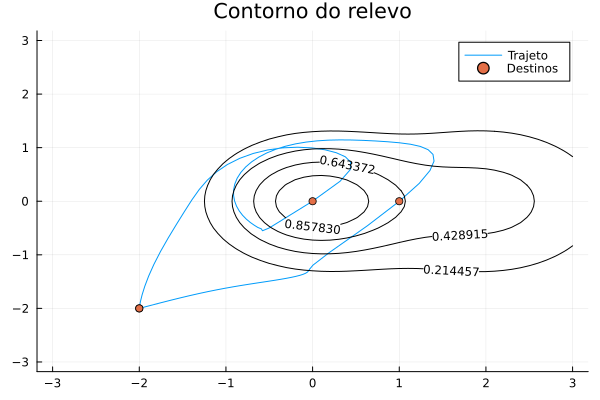

In [244]:
plot(path[:,1], path[:,2], label="Trajeto")
scatter!(wps[:,1], wps[:,2], label="Destinos")
contour!(-3:0.1:3, -3:0.1:3, basicTerrain, color=:black, clabels=true, levels=4, cbar=false, title="Contorno do relevo")

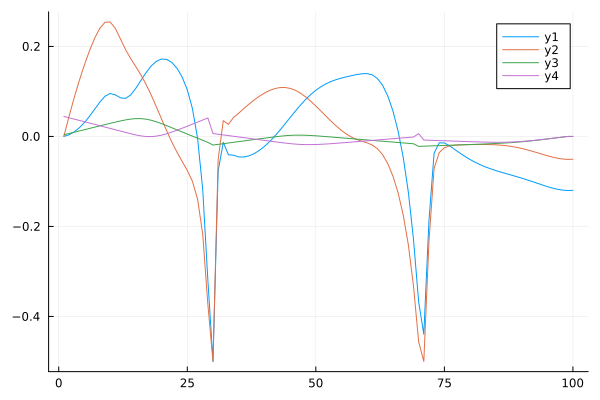

In [245]:
plot(velocity)
plot!(thrust)
#plot!(sqrt.(thrust[1,:].^2 + thrust[2,:].^2))
#plot!(basicTerrain.(path...))
